# Advection-Diffusion Equation: Analytical vs Numerical (Upwind Scheme)
## Jan Stryszewski
This notebook presents a numerical solution to the **1D advection-diffusion equation**, comparing it with the exact analytical solution using a Gaussian initial condition.

## 📘 Physical Context
This model describes the **transport of a substance** (e.g., pollutant, heat) in a one-dimensional domain due to:
- **Advection**: transport by a constant velocity flow,
- **Diffusion**: spreading due to molecular mixing.

Applications include:
- Groundwater pollution transport
- River pollutant dispersion
- Atmospheric aerosol modeling
- Heat conduction in solids

## 🧠 Governing Equation
We solve the 1D advection-diffusion equation:
$$\frac{\partial \psi}{\partial t} + u \frac{\partial \psi}{\partial x} = D \frac{\partial^2 \psi}{\partial x^2}$$

## 📐 Numerical Scheme: Upwind for Advection and Diffusion

We use the **upwind method** to approximate fluxes at cell interfaces.

**Advection Courant number:**

$$
C^{\text{adv}} = \frac{u\,dt}{dx}
$$

**Diffusion Courant number (adaptive):**

$$
C_{i-1/2}^{\text{diff}} = -2D\,\frac{dt}{dx^2}\,\frac{\psi_i - \psi_{i-1}}{\psi_i + \psi_{i-1}}
$$

This form is useful when concentrations vary across space. The denominator helps stabilize the scheme.

---

### 🔁 Full Update Formula

The concentration update using both advection and diffusion fluxes is:

$$
\psi_i^{n+1} = \psi_i^n
- \left[
F(\psi_i^n, \psi_{i+1}^n, C^{\text{adv}}) - F(\psi_{i-1}^n, \psi_i^n, C^{\text{adv}})
+ F(\psi_i^n, \psi_{i+1}^n, C_{i+1/2}^{\text{diff}}) - F(\psi_{i-1}^n, \psi_i^n, C_{i-1/2}^{\text{diff}})
\right]
$$

This combines **upwind advection** and **nonlinear diffusion** into a single update at each step.


## ✅ Analytical Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Psi0:
    def __init__(self, x0=5, a=1, sigma=25):
        self.x0 = x0
        self.a = a
        self.sigma = sigma

    def __call__(self, x):
        return self.a * np.exp(- (x - self.x0)**2 / (2 * self.sigma**2))

def psi_analytical(x, t, psi0_obj, u, D):
    sigma_eff = np.sqrt(psi0_obj.sigma**2 + 2*D*t)
    return psi0_obj.a * (psi0_obj.sigma / sigma_eff) * \
           np.exp(- (x - psi0_obj.x0 - u*t)**2 / (2 * sigma_eff**2))

## ⚙️ Numerical Simulation Setup

In [2]:
nx = 256
x_min, x_max = -100, 300
x, dx = np.linspace(x_min, x_max, nx, endpoint=False, retstep=True)

t_max = 50
nt = 2500
dt = t_max / nt

u = 2
D = 0.5

C_adv = u * dt / dx
C_diff = np.zeros(nx - 1)

psi0_obj = Psi0(x0=5, a=1, sigma=25)
psi_initial = psi0_obj(x)
psi = psi_initial.copy()

## ⚙️ Upwind Scheme + Diffusion

In [3]:
def F(psi_left, psi_right, C):
    return 0.5 * (C + np.abs(C)) * psi_left + 0.5 * (C - np.abs(C)) * psi_right

class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i): return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i): return slice(i.start - self.sub, i.stop - self.sub)

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

i = slice(1, nx-1)
im = slice(1, nx)

for n in range(nt):
    psi_old = psi.copy()
    flux_adv_right = F(psi_old[i], psi_old[i+one], C_adv)
    flux_adv_left = F(psi_old[i-one], psi_old[i], C_adv)
    adv_flux_diff = flux_adv_right - flux_adv_left

    denom = psi_old[im-one] + psi_old[im]
    safe_denom = np.where(denom != 0, denom, 1e-12)
    C_diff[im - hlf] = -2 * D * dt / dx**2 * (psi_old[im] - psi_old[im-one]) / safe_denom

    flux_diff_right = F(psi_old[i], psi_old[i+one], C_diff[i + hlf])
    flux_diff_left = F(psi_old[i-one], psi_old[i], C_diff[i - hlf])
    diff_flux_diff = flux_diff_right - flux_diff_left

    psi[i] = psi_old[i] - (adv_flux_diff + diff_flux_diff)

## 📊 Comparison: Analytical vs. Numerical

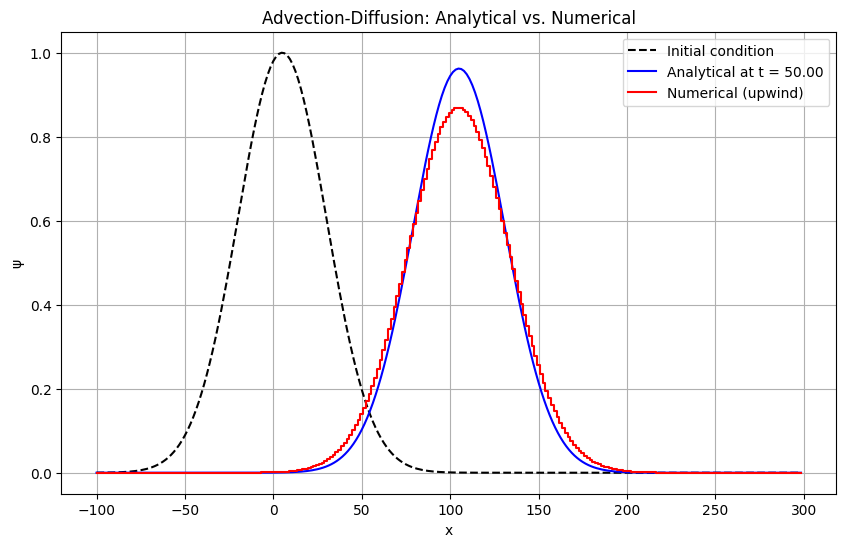

In [4]:
psi_exact = psi_analytical(x, t_max, psi0_obj, u, D)

plt.figure(figsize=(10, 6))
plt.plot(x, psi_initial, 'k--', label='Initial condition')
plt.plot(x, psi_exact, 'b-', label='Analytical at t = {:.2f}'.format(t_max))
plt.step(x, psi, 'r-', where='mid', label='Numerical (upwind)')
plt.xlabel('x')
plt.ylabel('ψ')
plt.title('Advection-Diffusion: Analytical vs. Numerical')
plt.legend()
plt.grid(True)
plt.show()

## 🧾 Conclusion
The numerical simulation using the **upwind scheme** closely matches the analytical solution for the 1D advection-diffusion equation. Despite small differences due to numerical diffusion, the model performs well.

### 📍 Applications:
- Groundwater or river pollution modeling
- Atmospheric or oceanic transport models
- Heat diffusion in solids